In [13]:
import igraph as g
import constants
import json
import math

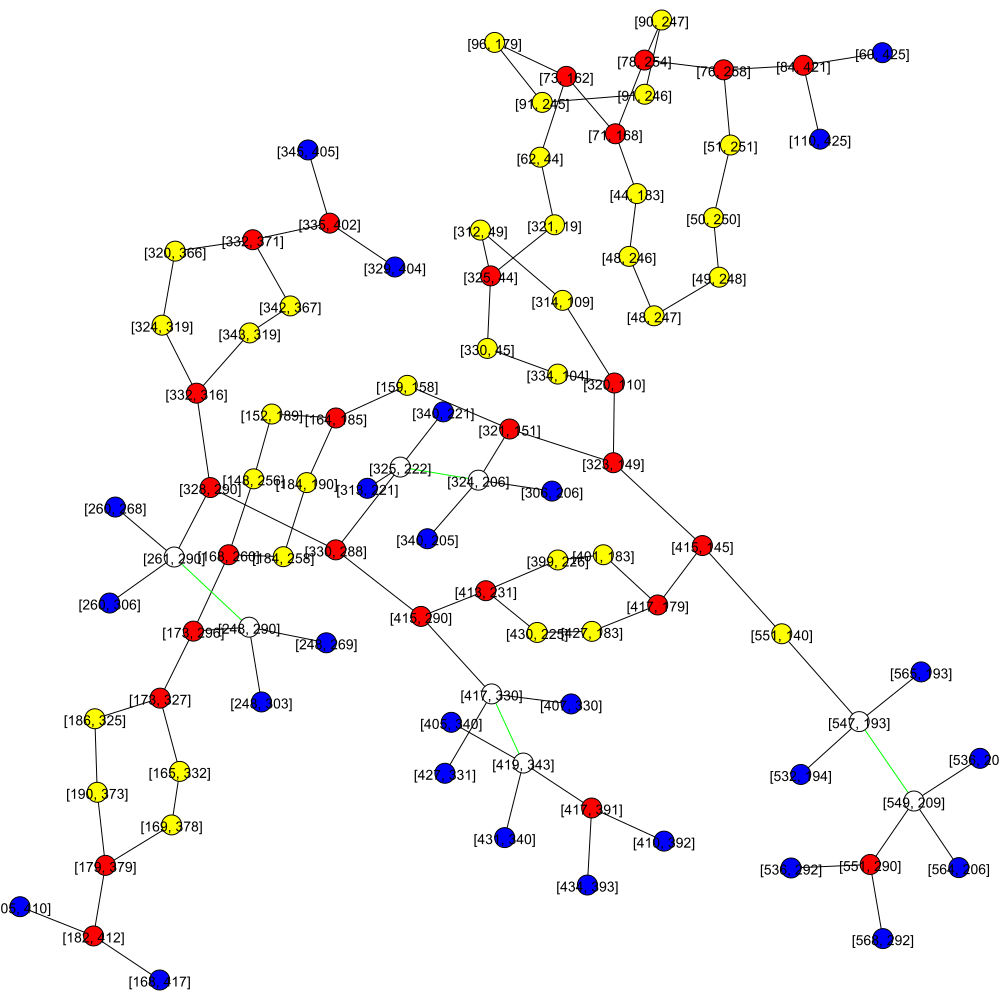

In [14]:
graph = g.Graph().Read("out.graph",format="graphml")

buildingPartNotes =[[(405, 340), (407, 330), (417, 330), (419, 343), (427, 331), (431, 340)]]

classifications = ["resistor","resistor","resistor"]

layout = graph.layout("large_graph")
g.plot(graph, layout=layout,bbox = (1000,1000))

## Make a singel Node out of the Components

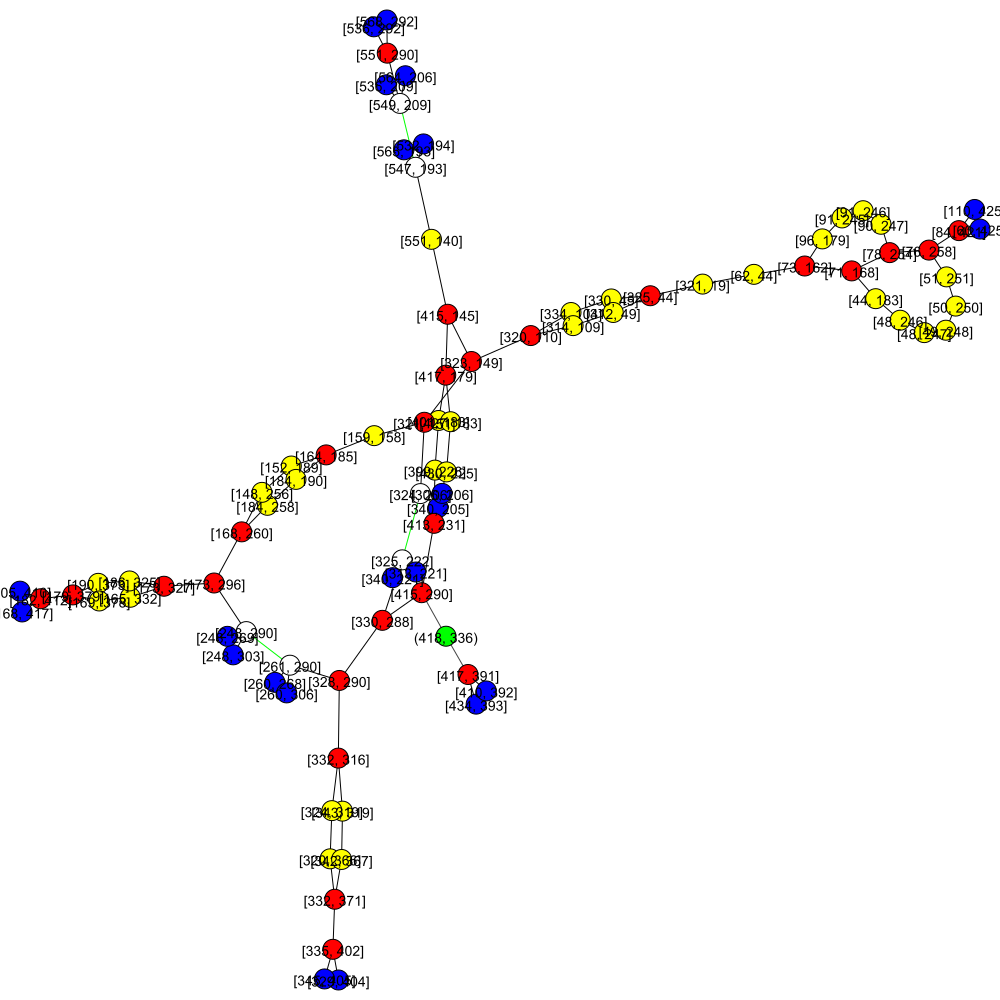

In [15]:
graph = g.Graph().Read("out.graph",format="graphml")

def getVertexByColor(graph,nodes,color):
    intersections = []
    for node in nodes:
        vertex = graph.vs.find(name_eq=node)
        if vertex["color"] == color:
            intersections.append(vertex)
    return intersections

def convertNameToTuble(graph):
    for i in range(0,len(graph.vs)):
        graph.vs[i]["name"] = (json.loads(graph.vs[i]["name"])[0],json.loads(graph.vs[i]["name"])[1])
    return graph

def getNeighborVertices(graph,vertex):
    neighbors = graph.neighbors(vertex)
    neighbors = list(map(lambda id: graph.vs.find(id),neighbors))
    return neighbors

# componentVertices -> All the Vertecies that represent a component
# compType -> describing the type of the component: resistor, cap...
# connectionDic -> A Dic with the vertices, representing the "component" connections. The key is the order of the Connection (ordertd Top left to bottom right)
def replaceComponent(graph,componentVertices,compType,connectionDic):

    # Calc center of connections
    coordinates = list(map(lambda x: x["name"],connectionDic.values()))
    xCoords = list(zip(*coordinates))[0]
    yCoords = list(zip(*coordinates))[1]
    center = round(sum(xCoords)/len(xCoords)),round(sum(yCoords)/len(yCoords))

    #replace every connection with the real neighbour vertex
    for key in sorted(connectionDic):
        neighbors = list(map(lambda vertex:vertex["name"],getNeighborVertices(graph,connectionDic[key])))
        for neighbor in neighbors:
            if not neighbor in componentVertices:
                vertex = graph.vs.find(name_eq=neighbor)
                connectionDic[key] = vertex
                break

    connectionCooordinates = {}
    for key in sorted(connectionDic):
        connectionCooordinates[key] = connectionDic[key]["name"]
    #create new component vertex
    graph.add_vertex(name=center,label=str(center),componentType=compType,connectionMap=connectionCooordinates,color=constants.COMPONENT_NODE_COLOR)
    centerVertex = graph.vs.find(name_eq = center)

    #create connections
    for vertex in connectionDic.values():
        graph.add_edge(vertex,centerVertex)

    # removing all componentVertices
    for componentVertex in componentVertices:
        graph.delete_vertices([graph.vs.find(name_eq=componentVertex)])
    


    return graph

# componentVertices -> All the Vertecies that represent a component
# Gets all the connection Points to a Component and orders them top left to bottom right
def generateConnectionDic(graph,componentVertices):
    #Get connection Points
    connections = getVertexByColor(graph,componentVertices,constants.INTERSECTION_COLOR) + getVertexByColor(graph,componentVertices,constants.OTHER_NODE_COLOR)
    
    #Order by top left to bottom right
    #Group Connections whose Y values differ in only 20 Pixels
    dic = {}
    for connection in connections:
        key = math.floor(connection["name"][1]/40)*40
        if key in dic:
            dic[key].append(connection)
        else:
            dic[key] = [connection]

    # now sort every category left to right
    # and recombine them into a list
    out = []
    for key in sorted(dic):
        out += sorted(dic[key],key=lambda x:x["name"][0])

    return dict(zip(range(0,len(out)),out))


graph = convertNameToTuble(graph)

#for every component
for b in buildingPartNotes:
    connectionDic = generateConnectionDic(graph,b)
    graph = replaceComponent(graph,b,constants.RESISTOR_TYPE,connectionDic)

layout = graph.layout("fr")
g.plot(graph, layout=layout,bbox = (1000,1000))

## Now scale the whole Cuircit to fit the LT-Spice Cuircit

* Get the avarage Resistor Size
* Convert the cooridantes in the Cuircit to the Reisistorsize unit (1 Unit = Size of a Resistor)

In [23]:
#STEP 1: Avare Resistor Lenght
# get all Resistors
resistors = graph.vs.select(componentType=constants.RESISTOR_TYPE)
# for every Resistor calc lenght
def calcComponentLenght(componentVertex):
    xCoords,yCoords = zip(*componentVertex["connectionMap"].values())
    xLenght = max(xCoords) - min(xCoords)
    yLenght = max(yCoords) - min(yCoords)
    if xLenght > yLenght:
        return xLenght
    return yLenght

avrResistorLenght = sum(map(calcComponentLenght,resistors))/len(resistors)
print(avrResistorLenght)

101.0
